# IF867 - Introdução à Aprendizagem Profunda
## 1ª atividade prática - 2025.1

Discente(s):
- Ana Sofia Lima (asosl)
- João Vitor Mergulhão (jvlm2)

## Instruções e requisitos
- Objetivo: Implementar e treinar um Multi-Layer Perceptron e uma Rede Neural Convolucional, inteiramente em PyTorch.
- Observação: A atividade pode ser feita em dupla.

## Tarefa

Multi-Layer Perceptron (MLP) para Regressão (50% da nota):
  - Implementação: Construa um MLP funcional para uma tarefa de regressão.
  - Experimentação:
      - Varie a arquitetura da rede (ex: número de camadas, neurônios por camada).
      - Teste diferentes otimizadores (ex: Adam, SGD).
      - Explore outras modificações que julgar pertinentes.
  - Relatório: Documente no notebook os experimentos realizados, as configurações utilizadas e os resultados obtidos, analisando o impacto de cada alteração.

O relatório está ao fim do notebook.

## Dataset

In [77]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [78]:
import pandas as pd

import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tqdm import tqdm

from matplotlib import pyplot as plt

In [79]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
student_performance = fetch_ucirepo(id=320)

# metadata
print(student_performance.metadata)

# variable information
print(student_performance.variables)

{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing


In [81]:
# separação dos dados em features e target
X = student_performance.data.features.copy()

y = student_performance.data.targets["G3"].copy()

In [82]:
# Label encoding para as features binárias
binary_map_cols = ["schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic", "sex"]

for col in binary_map_cols:
  if col == "sex":
    X["sex"] = X[col].map({"F": 0, "M": 1}).astype("int64")
  else:
    X[col] = X[col].map({"no": 0, "yes": 1})

In [83]:
# One-hot encoding para as features categóricas
categorical_cols = X.select_dtypes(include="object").columns.tolist()
print(categorical_cols)

['school', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian']


In [84]:
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(X[categorical_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_cols))

X = X.drop(categorical_cols, axis=1)

In [85]:
numerical_cols = list(set(X.columns) - set(binary_map_cols) - set(categorical_cols))
print(numerical_cols)

['Fedu', 'health', 'Walc', 'failures', 'traveltime', 'goout', 'studytime', 'famrel', 'absences', 'age', 'Dalc', 'freetime', 'Medu']


In [86]:
# Standard Scaling para as features numéricas
scaler = StandardScaler()
scaled_num = scaler.fit_transform(X[numerical_cols])
scaled_num_df = pd.DataFrame(scaled_num, columns=numerical_cols, index=X.index)

In [87]:
X_processed = pd.concat([one_hot_df, scaled_num_df, X[binary_map_cols]], axis=1)

In [88]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   school_GP          649 non-null    float64
 1   school_MS          649 non-null    float64
 2   address_R          649 non-null    float64
 3   address_U          649 non-null    float64
 4   famsize_GT3        649 non-null    float64
 5   famsize_LE3        649 non-null    float64
 6   Pstatus_A          649 non-null    float64
 7   Pstatus_T          649 non-null    float64
 8   Mjob_at_home       649 non-null    float64
 9   Mjob_health        649 non-null    float64
 10  Mjob_other         649 non-null    float64
 11  Mjob_services      649 non-null    float64
 12  Mjob_teacher       649 non-null    float64
 13  Fjob_at_home       649 non-null    float64
 14  Fjob_health        649 non-null    float64
 15  Fjob_other         649 non-null    float64
 16  Fjob_services      649 non

In [89]:
# separa treino e teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# separa treino e validação a partir do conjunto temporário
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 do total
)

In [90]:
# Convertemos os DataFrames para tensores float32
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

In [91]:
# Datasets e Dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [92]:
def evaluate(model, dataloader, criterion, device="cpu"):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(dataloader.dataset)

## Train Loop

In [93]:
# treinamento
# Early stopping setup
def trainModel(model, train_loader, val_loader, criterion, optimizer, n_epochs=50, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_losses = []
    val_losses = []
    best_loss = float("inf")
    patience_counter = 0
    best_model_state = None

    model.to(device)

    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)

        epoch_loss /= len(train_loader.dataset)
        train_losses.append(epoch_loss)
        tqdm.write(f"Epoch {epoch+1} training loss: {epoch_loss:.4f}")

        # Avaliação
        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        tqdm.write(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write("Early stopping triggered.")
                break

    # Carregar melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        torch.save(model.state_dict(), "melhor_modelo.pth")

    return train_losses, val_losses

In [94]:
class ModelBaseline(nn.Module):
    def __init__(self):
        super(ModelBaseline, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(47, 120),
            nn.Linear(120, 120),
            nn.Linear(120, 1)
        )

    def forward(self, x):
        return self.net(x)

In [95]:
# Hiperparâmetros
n_epochs = 30
lr=1e-3
patience = 5

model = ModelBaseline()

criterion = nn.MSELoss()  # regressão → MSE
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses = trainModel(model,
           train_loader,
           val_loader,
           criterion,
           optimizer,
           n_epochs,
           patience)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 training loss: 123.1960
Epoch 1 validation loss: 81.3687


  7%|▋         | 2/30 [00:00<00:01, 17.20it/s]

Epoch 2 training loss: 42.2687
Epoch 2 validation loss: 8.4033


 13%|█▎        | 4/30 [00:00<00:01, 16.69it/s]

Epoch 3 training loss: 14.3194
Epoch 3 validation loss: 8.8940
Epoch 4 training loss: 9.6977
Epoch 4 validation loss: 8.6920


 13%|█▎        | 4/30 [00:00<00:01, 16.69it/s]

Epoch 5 training loss: 9.0791
Epoch 5 validation loss: 7.6768


 13%|█▎        | 4/30 [00:00<00:01, 16.69it/s]

Epoch 6 training loss: 8.4638
Epoch 6 validation loss: 7.5612


 23%|██▎       | 7/30 [00:00<00:01, 19.03it/s]

Epoch 7 training loss: 8.4139
Epoch 7 validation loss: 7.2001
Epoch 8 training loss: 7.8693
Epoch 8 validation loss: 7.2013
Epoch 9 training loss: 7.9598
Epoch 9 validation loss: 6.8025


 33%|███▎      | 10/30 [00:00<00:00, 20.70it/s]

Epoch 10 training loss: 7.6340
Epoch 10 validation loss: 6.7827


 33%|███▎      | 10/30 [00:00<00:00, 20.70it/s]

Epoch 11 training loss: 7.5628
Epoch 11 validation loss: 6.7259


 43%|████▎     | 13/30 [00:00<00:00, 21.47it/s]

Epoch 12 training loss: 7.6059
Epoch 12 validation loss: 6.8160
Epoch 13 training loss: 7.4018
Epoch 13 validation loss: 6.6890
Epoch 14 training loss: 7.4336
Epoch 14 validation loss: 6.6102


 43%|████▎     | 13/30 [00:00<00:00, 21.47it/s]

Epoch 15 training loss: 7.3296
Epoch 15 validation loss: 6.5436


 53%|█████▎    | 16/30 [00:00<00:00, 22.43it/s]

Epoch 16 training loss: 7.3445
Epoch 16 validation loss: 6.4759


 63%|██████▎   | 19/30 [00:00<00:00, 22.63it/s]

Epoch 17 training loss: 7.2019
Epoch 17 validation loss: 6.3640
Epoch 18 training loss: 7.1543
Epoch 18 validation loss: 6.6519
Epoch 19 training loss: 7.4339
Epoch 19 validation loss: 6.8415


 63%|██████▎   | 19/30 [00:00<00:00, 22.63it/s]

Epoch 20 training loss: 7.2312
Epoch 20 validation loss: 6.4570


 63%|██████▎   | 19/30 [00:00<00:00, 22.63it/s]

Epoch 21 training loss: 7.0790
Epoch 21 validation loss: 6.3615


 73%|███████▎  | 22/30 [00:01<00:00, 23.10it/s]

Epoch 22 training loss: 7.0025
Epoch 22 validation loss: 6.2146
Epoch 23 training loss: 7.1465
Epoch 23 validation loss: 6.3256
Epoch 24 training loss: 7.0264
Epoch 24 validation loss: 6.2822


 83%|████████▎ | 25/30 [00:01<00:00, 23.52it/s]

Epoch 25 training loss: 7.1057
Epoch 25 validation loss: 6.2144


 83%|████████▎ | 25/30 [00:01<00:00, 23.52it/s]

Epoch 26 training loss: 7.0218
Epoch 26 validation loss: 6.3205


 93%|█████████▎| 28/30 [00:01<00:00, 22.83it/s]

Epoch 27 training loss: 6.9834
Epoch 27 validation loss: 6.2601
Epoch 28 training loss: 6.9647
Epoch 28 validation loss: 6.5655
Epoch 29 training loss: 7.1346
Epoch 29 validation loss: 6.3469


 97%|█████████▋| 29/30 [00:01<00:00, 21.32it/s]

Epoch 30 training loss: 7.0326
Epoch 30 validation loss: 6.3867
Early stopping triggered.


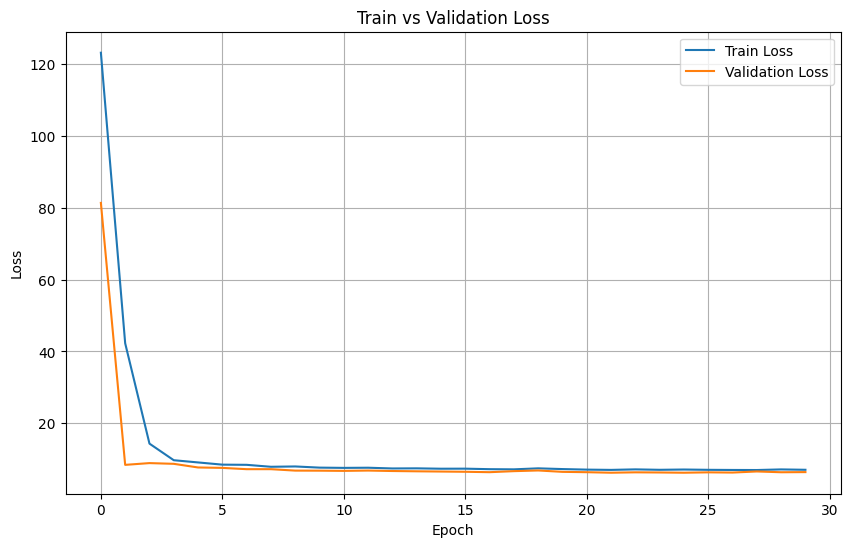

In [96]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Previsões
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# Transformando y_test para array (caso ainda seja Series)
y_true = y_test_tensor.cpu().numpy()

# Cálculo das métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.2323
RMSE: 2.9334
R²:   0.1176


## Test of baseline

In [98]:
index = 75
student = X_test_tensor[index]
y_true = y_test_tensor[index]
y_true

tensor([12.], device='cuda:0')

In [99]:
with torch.no_grad():
    y_pred = model(student).cpu().numpy()
y_pred

array([11.71803], dtype=float32)

## Experiment 1: Changing the architecture - layers

In [100]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(47, 120),
            nn.Linear(120, 120),
            nn.Linear(120, 120),
            nn.Linear(120, 1)
        )

    def forward(self, x):
        return self.net(x)

In [101]:
# Hiperparâmetros
n_epochs = 30
lr=1e-3
patience = 5

model = Model1()

criterion = nn.MSELoss()  # regressão → MSE
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses = trainModel(model,
           train_loader,
           val_loader,
           criterion,
           optimizer,
           n_epochs,
           patience)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 training loss: 115.2547
Epoch 1 validation loss: 42.2473


 10%|█         | 3/30 [00:00<00:01, 21.01it/s]

Epoch 2 training loss: 24.2632
Epoch 2 validation loss: 7.7425
Epoch 3 training loss: 12.5598
Epoch 3 validation loss: 7.6699


 10%|█         | 3/30 [00:00<00:01, 21.01it/s]

Epoch 4 training loss: 9.0843
Epoch 4 validation loss: 7.1109
Epoch 5 training loss: 8.3255
Epoch 5 validation loss: 6.9056


 20%|██        | 6/30 [00:00<00:01, 21.43it/s]

Epoch 6 training loss: 7.9365
Epoch 6 validation loss: 7.0840


 20%|██        | 6/30 [00:00<00:01, 21.43it/s]

Epoch 7 training loss: 8.0907
Epoch 7 validation loss: 7.3931
Epoch 8 training loss: 7.9089
Epoch 8 validation loss: 6.5939


 30%|███       | 9/30 [00:00<00:01, 20.77it/s]

Epoch 9 training loss: 7.5619
Epoch 9 validation loss: 6.8477
Epoch 10 training loss: 7.6797


Epoch 10 validation loss: 7.0435
Epoch 11 training loss: 7.5564


 40%|████      | 12/30 [00:00<00:00, 20.72it/s]

Epoch 11 validation loss: 6.3845
Epoch 12 training loss: 7.3770
Epoch 12 validation loss: 6.4855
Epoch 13 training loss: 7.2577
Epoch 13 validation loss: 6.4396


 40%|████      | 12/30 [00:00<00:00, 20.72it/s]

Epoch 14 training loss: 7.3629
Epoch 14 validation loss: 6.9030
Epoch 15 training loss: 7.3644
Epoch 15 validation loss: 6.2449


 53%|█████▎    | 16/30 [00:00<00:00, 24.32it/s]

Epoch 16 training loss: 7.2124
Epoch 16 validation loss: 6.4360
Epoch 17 training loss: 7.0808


 67%|██████▋   | 20/30 [00:00<00:00, 26.58it/s]

Epoch 17 validation loss: 6.4892
Epoch 18 training loss: 7.0538
Epoch 18 validation loss: 6.5474
Epoch 19 training loss: 7.2739
Epoch 19 validation loss: 6.2389
Epoch 20 training loss: 7.0313
Epoch 20 validation loss: 6.1618


 67%|██████▋   | 20/30 [00:00<00:00, 26.58it/s]

Epoch 21 training loss: 6.9923
Epoch 21 validation loss: 6.3247
Epoch 22 training loss: 7.0533
Epoch 22 validation loss: 6.4522


 67%|██████▋   | 20/30 [00:00<00:00, 26.58it/s]

Epoch 23 training loss: 7.1896
Epoch 23 validation loss: 6.1715


 80%|████████  | 24/30 [00:00<00:00, 24.04it/s]


Epoch 24 training loss: 7.2230
Epoch 24 validation loss: 6.3794
Epoch 25 training loss: 6.9940
Epoch 25 validation loss: 6.2946
Early stopping triggered.


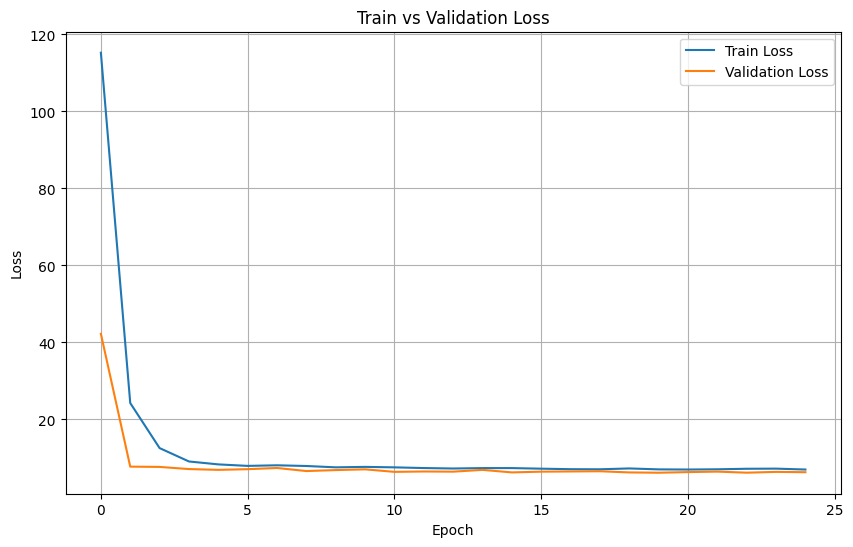

In [102]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Previsões
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# Transformando y_test para array (caso ainda seja Series)
y_true = y_test_tensor.cpu().numpy()

# Cálculo das métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.1880
RMSE: 2.9014
R²:   0.1368


In [104]:
index = 75
student = X_test_tensor[index]
y_true = y_test_tensor[index]
y_true

tensor([12.], device='cuda:0')

In [105]:
with torch.no_grad():
    y_pred = model(student).cpu().numpy()
y_pred

array([11.17095], dtype=float32)

## Experiment 2: Changing the architecture - neurons

In [106]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(47, 256),
            nn.Linear(256, 256),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)

In [107]:
# Hiperparâmetros
n_epochs = 30
lr=1e-3
patience = 5

model = Model2()

criterion = nn.MSELoss()  # regressão → MSE
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses = trainModel(model,
           train_loader,
           val_loader,
           criterion,
           optimizer,
           n_epochs,
           patience)

 10%|█         | 3/30 [00:00<00:00, 28.39it/s]

Epoch 1 training loss: 88.2107
Epoch 1 validation loss: 11.7760
Epoch 2 training loss: 16.5550
Epoch 2 validation loss: 7.1847
Epoch 3 training loss: 10.7799
Epoch 3 validation loss: 7.9912
Epoch 4 training loss: 8.9173
Epoch 4 validation loss: 7.2444


 20%|██        | 6/30 [00:00<00:00, 28.23it/s]

Epoch 5 training loss: 8.1330
Epoch 5 validation loss: 7.1714
Epoch 6 training loss: 7.8333
Epoch 6 validation loss: 7.1589


 30%|███       | 9/30 [00:00<00:00, 28.10it/s]

Epoch 7 training loss: 7.5828
Epoch 7 validation loss: 6.8259
Epoch 8 training loss: 7.3870
Epoch 8 validation loss: 6.7991
Epoch 9 training loss: 7.3067
Epoch 9 validation loss: 6.6295
Epoch 10 training loss: 7.5362
Epoch 10 validation loss: 6.9783


 40%|████      | 12/30 [00:00<00:00, 28.09it/s]

Epoch 11 training loss: 7.5326
Epoch 11 validation loss: 6.8148
Epoch 12 training loss: 7.2646
Epoch 12 validation loss: 6.7501


 50%|█████     | 15/30 [00:00<00:00, 28.10it/s]

Epoch 13 training loss: 7.1760
Epoch 13 validation loss: 6.5645
Epoch 14 training loss: 7.0947
Epoch 14 validation loss: 6.6362
Epoch 15 training loss: 7.0324
Epoch 15 validation loss: 6.5816
Epoch 16 training loss: 7.2698
Epoch 16 validation loss: 6.4105


 60%|██████    | 18/30 [00:00<00:00, 28.54it/s]

Epoch 17 training loss: 7.3771
Epoch 17 validation loss: 6.5886
Epoch 18 training loss: 7.2524
Epoch 18 validation loss: 6.5926


 70%|███████   | 21/30 [00:00<00:00, 27.84it/s]

Epoch 19 training loss: 7.1522
Epoch 19 validation loss: 6.4962
Epoch 20 training loss: 7.1112
Epoch 20 validation loss: 6.3831
Epoch 21 training loss: 7.0585
Epoch 21 validation loss: 6.1711
Epoch 22 training loss: 6.9945
Epoch 22 validation loss: 6.2116


 80%|████████  | 24/30 [00:00<00:00, 27.52it/s]

Epoch 23 training loss: 7.0703
Epoch 23 validation loss: 6.0538
Epoch 24 training loss: 7.0062
Epoch 24 validation loss: 6.1364


 90%|█████████ | 27/30 [00:01<00:00, 26.73it/s]

Epoch 25 training loss: 7.0016
Epoch 25 validation loss: 6.1190
Epoch 26 training loss: 7.3509
Epoch 26 validation loss: 6.2757
Epoch 27 training loss: 7.0700
Epoch 27 validation loss: 6.2449
Epoch 28 training loss: 7.0598
Epoch 28 validation loss: 6.0750
Early stopping triggered.


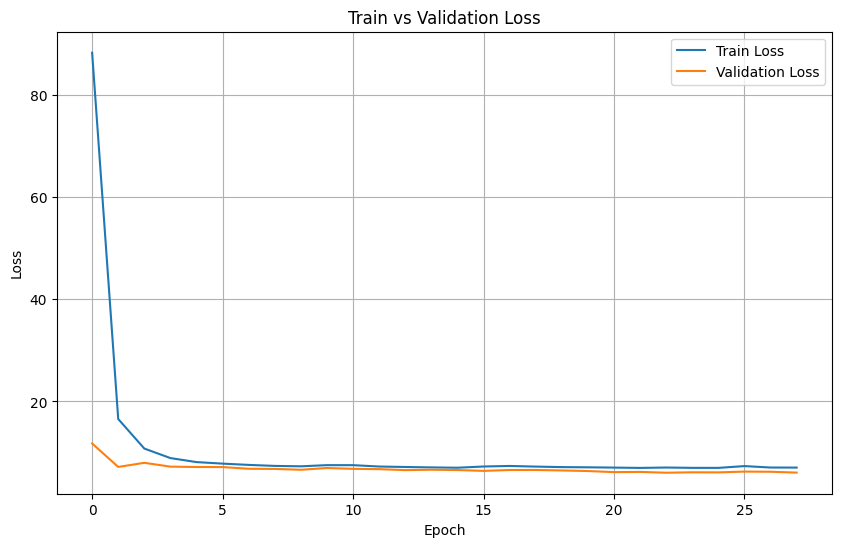

In [108]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [109]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Previsões
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# Transformando y_test para array (caso ainda seja Series)
y_true = y_test_tensor.cpu().numpy()

# Cálculo das métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.1941
RMSE: 2.8965
R²:   0.1397


In [110]:
index = 75
student = X_test_tensor[index]
y_true = y_test_tensor[index]
y_true

tensor([12.], device='cuda:0')

In [111]:
with torch.no_grad():
    y_pred = model(student).cpu().numpy()
y_pred

array([10.950475], dtype=float32)

## Experiment 3: Changing the optmizer - SGD with momentum

In [112]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(47, 120),
            nn.Linear(120, 120),
            nn.Linear(120, 1)
        )

    def forward(self, x):
        return self.net(x)

In [113]:
# Hiperparâmetros
n_epochs = 30
lr=1e-3
patience = 5

model = Model3()

criterion = nn.MSELoss()  # regressão → MSE
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

train_losses, val_losses = trainModel(model,
           train_loader,
           val_loader,
           criterion,
           optimizer,
           n_epochs,
           patience)

 13%|█▎        | 4/30 [00:00<00:00, 34.21it/s]

Epoch 1 training loss: 80.6386
Epoch 1 validation loss: 12.9677
Epoch 2 training loss: 29.2520
Epoch 2 validation loss: 11.1417
Epoch 3 training loss: 15.3996
Epoch 3 validation loss: 8.9850
Epoch 4 training loss: 9.2408
Epoch 4 validation loss: 9.3724
Epoch 5 training loss: 8.8263
Epoch 5 validation loss: 7.7634


 13%|█▎        | 4/30 [00:00<00:00, 34.21it/s]

Epoch 6 training loss: 7.5409
Epoch 6 validation loss: 6.6261
Epoch 7 training loss: 7.3236
Epoch 7 validation loss: 6.3508


 27%|██▋       | 8/30 [00:00<00:00, 31.13it/s]

Epoch 8 training loss: 7.6295
Epoch 8 validation loss: 6.8995
Epoch 9 training loss: 7.5857
Epoch 9 validation loss: 6.2042
Epoch 10 training loss: 7.2441
Epoch 10 validation loss: 6.5694
Epoch 11 training loss: 7.2190
Epoch 11 validation loss: 6.2145


 40%|████      | 12/30 [00:00<00:00, 29.87it/s]

Epoch 12 training loss: 7.2872
Epoch 12 validation loss: 6.3014
Epoch 13 training loss: 7.5097
Epoch 13 validation loss: 6.6351


 53%|█████▎    | 16/30 [00:00<00:00, 29.60it/s]

Epoch 14 training loss: 7.6611
Epoch 14 validation loss: 5.9223
Epoch 15 training loss: 7.7052
Epoch 15 validation loss: 7.5803
Epoch 16 training loss: 7.6744
Epoch 16 validation loss: 6.8773
Epoch 17 training loss: 7.8677
Epoch 17 validation loss: 6.6940


 60%|██████    | 18/30 [00:00<00:00, 28.34it/s]

Epoch 18 training loss: 7.2804
Epoch 18 validation loss: 7.4207
Epoch 19 training loss: 7.3513
Epoch 19 validation loss: 5.9948
Early stopping triggered.


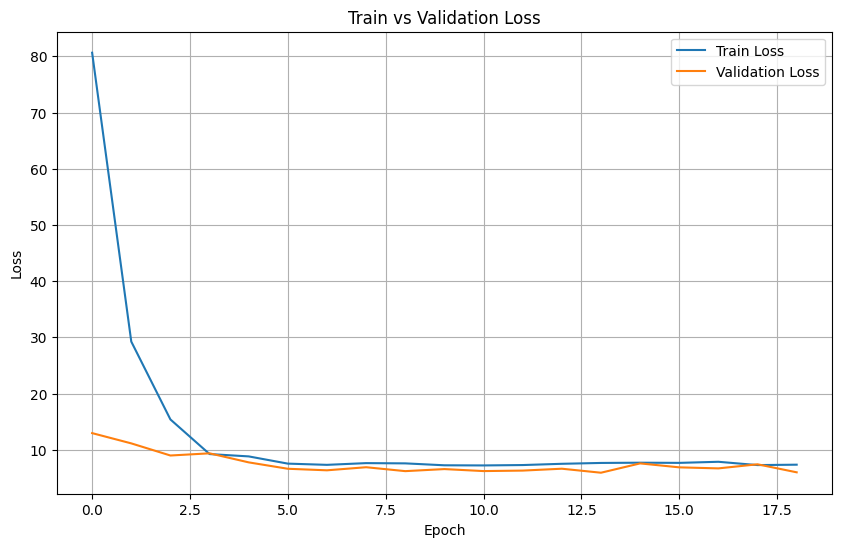

In [114]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Previsões
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# Transformando y_test para array (caso ainda seja Series)
y_true = y_test_tensor.cpu().numpy()

# Cálculo das métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.1961
RMSE: 2.8816
R²:   0.1485


In [116]:
index = 75
student = X_test_tensor[index]
y_true = y_test_tensor[index]
y_true

tensor([12.], device='cuda:0')

In [117]:
with torch.no_grad():
    y_pred = model(student).cpu().numpy()
y_pred

array([11.776897], dtype=float32)

## Experiment 4: Changing the optmizer - AdamW

In [118]:
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(47, 120),
            nn.Linear(120, 120),
            nn.Linear(120, 1)
        )

    def forward(self, x):
        return self.net(x)

In [119]:
# Hiperparâmetros
n_epochs = 30
lr=1e-3
patience = 5

model = Model4()

criterion = nn.MSELoss()  # regressão → MSE
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

train_losses, val_losses = trainModel(model,
           train_loader,
           val_loader,
           criterion,
           optimizer,
           n_epochs,
           patience)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 training loss: 125.3770
Epoch 1 validation loss: 87.0997


 13%|█▎        | 4/30 [00:00<00:00, 28.81it/s]

Epoch 2 training loss: 46.8048
Epoch 2 validation loss: 9.1775
Epoch 3 training loss: 14.6919
Epoch 3 validation loss: 9.2036
Epoch 4 training loss: 10.3370
Epoch 4 validation loss: 8.2508


 13%|█▎        | 4/30 [00:00<00:00, 28.81it/s]

Epoch 5 training loss: 8.7246
Epoch 5 validation loss: 7.3898
Epoch 6 training loss: 8.4119
Epoch 6 validation loss: 7.0641


 23%|██▎       | 7/30 [00:00<00:00, 27.61it/s]

Epoch 7 training loss: 8.1122
Epoch 7 validation loss: 7.1557


 33%|███▎      | 10/30 [00:00<00:00, 27.01it/s]

Epoch 8 training loss: 7.8213
Epoch 8 validation loss: 7.1034
Epoch 9 training loss: 7.6581
Epoch 9 validation loss: 6.9134
Epoch 10 training loss: 7.5282
Epoch 10 validation loss: 6.9018


 33%|███▎      | 10/30 [00:00<00:00, 27.01it/s]

Epoch 11 training loss: 7.6681
Epoch 11 validation loss: 6.7666
Epoch 12 training loss: 7.4143


 33%|███▎      | 10/30 [00:00<00:00, 27.01it/s]

Epoch 12 validation loss: 6.7223
Epoch 13 training loss: 7.2629


 53%|█████▎    | 16/30 [00:00<00:00, 27.45it/s]

Epoch 13 validation loss: 6.6452
Epoch 14 training loss: 7.2969
Epoch 14 validation loss: 6.6135
Epoch 15 training loss: 7.1788
Epoch 15 validation loss: 6.5253
Epoch 16 training loss: 7.2081
Epoch 16 validation loss: 6.3913


 53%|█████▎    | 16/30 [00:00<00:00, 27.45it/s]

Epoch 17 training loss: 7.4022
Epoch 17 validation loss: 6.7054


 53%|█████▎    | 16/30 [00:00<00:00, 27.45it/s]

Epoch 18 training loss: 7.2205
Epoch 18 validation loss: 7.0710
Epoch 19 training loss: 7.2049


 73%|███████▎  | 22/30 [00:00<00:00, 28.09it/s]

Epoch 19 validation loss: 6.5849
Epoch 20 training loss: 7.1016
Epoch 20 validation loss: 6.3210
Epoch 21 training loss: 7.0459
Epoch 21 validation loss: 6.2207
Epoch 22 training loss: 7.0860
Epoch 22 validation loss: 6.2137


 73%|███████▎  | 22/30 [00:00<00:00, 28.09it/s]

Epoch 23 training loss: 6.9618
Epoch 23 validation loss: 6.3414


 73%|███████▎  | 22/30 [00:00<00:00, 28.09it/s]

Epoch 24 training loss: 6.9910
Epoch 24 validation loss: 6.3538


 93%|█████████▎| 28/30 [00:01<00:00, 27.85it/s]

Epoch 25 training loss: 6.9559
Epoch 25 validation loss: 6.2482
Epoch 26 training loss: 7.0371
Epoch 26 validation loss: 6.3142
Epoch 27 training loss: 6.9461
Epoch 27 validation loss: 6.2105
Epoch 28 training loss: 6.9837
Epoch 28 validation loss: 6.3553


 93%|█████████▎| 28/30 [00:01<00:00, 27.85it/s]

Epoch 29 training loss: 6.9159
Epoch 29 validation loss: 6.2882


100%|██████████| 30/30 [00:01<00:00, 27.70it/s]

Epoch 30 training loss: 7.0103
Epoch 30 validation loss: 6.4999


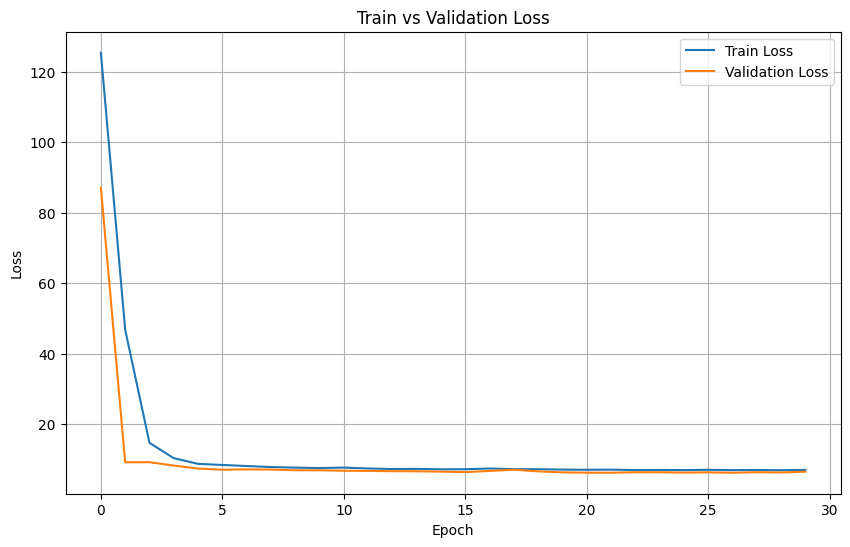

In [120]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [121]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Previsões
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# Transformando y_test para array (caso ainda seja Series)
y_true = y_test_tensor.cpu().numpy()

# Cálculo das métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.1918
RMSE: 2.9084
R²:   0.1326


In [122]:
index = 75
student = X_test_tensor[index]
y_true = y_test_tensor[index]
y_true

tensor([12.], device='cuda:0')

In [123]:
with torch.no_grad():
    y_pred = model(student).cpu().numpy()
y_pred

array([11.192607], dtype=float32)

## Experiment 5: Adding dropout

In [124]:
class Model5(nn.Module):
    def __init__(self):
        super(Model5, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(47, 120),
            nn.Dropout(0.2),
            nn.Linear(120, 120),
            nn.Dropout(0.2),
            nn.Linear(120, 1)
        )

    def forward(self, x):
        return self.net(x)

In [125]:
# Hiperparâmetros
n_epochs = 30
lr=1e-3
patience = 5

model = Model5()

criterion = nn.MSELoss()  # regressão → MSE
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

train_losses, val_losses = trainModel(model,
           train_loader,
           val_loader,
           criterion,
           optimizer,
           n_epochs,
           patience)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 training loss: 122.1559


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 validation loss: 84.6841
Epoch 2 training loss: 49.0963


 10%|█         | 3/30 [00:00<00:01, 26.24it/s]

Epoch 2 validation loss: 9.8191
Epoch 3 training loss: 14.3151
Epoch 3 validation loss: 9.8144
Epoch 4 training loss: 11.1412
Epoch 4 validation loss: 8.9361


 10%|█         | 3/30 [00:00<00:01, 26.24it/s]

Epoch 5 training loss: 9.5717
Epoch 5 validation loss: 7.6136


 20%|██        | 6/30 [00:00<00:01, 21.80it/s]

Epoch 6 training loss: 9.4180
Epoch 6 validation loss: 7.4840


 20%|██        | 6/30 [00:00<00:01, 21.80it/s]

Epoch 7 training loss: 9.2849
Epoch 7 validation loss: 7.3714
Epoch 8 training loss: 8.7462
Epoch 8 validation loss: 7.2787


 30%|███       | 9/30 [00:00<00:01, 20.88it/s]

Epoch 9 training loss: 8.2673
Epoch 9 validation loss: 7.3068
Epoch 10 training loss: 9.3766


 30%|███       | 9/30 [00:00<00:01, 20.88it/s]

Epoch 10 validation loss: 7.0861
Epoch 11 training loss: 8.4594
Epoch 11 validation loss: 7.0536


 40%|████      | 12/30 [00:00<00:00, 21.44it/s]

Epoch 12 training loss: 8.6601
Epoch 12 validation loss: 6.9993
Epoch 13 training loss: 8.2695
Epoch 13 validation loss: 6.9607
Epoch 14 training loss: 8.4388


 50%|█████     | 15/30 [00:00<00:00, 23.81it/s]

Epoch 14 validation loss: 6.8251
Epoch 15 training loss: 8.6268
Epoch 15 validation loss: 6.7240


 50%|█████     | 15/30 [00:00<00:00, 23.81it/s]

Epoch 16 training loss: 8.1079
Epoch 16 validation loss: 6.7193
Epoch 17 training loss: 8.2466
Epoch 17 validation loss: 6.6487


 60%|██████    | 18/30 [00:00<00:00, 25.49it/s]

Epoch 18 training loss: 8.5360
Epoch 18 validation loss: 6.6213
Epoch 19 training loss: 7.9994
Epoch 19 validation loss: 6.4792
Epoch 20 training loss: 8.3149
Epoch 20 validation loss: 6.2520


 60%|██████    | 18/30 [00:00<00:00, 25.49it/s]

Epoch 21 training loss: 7.8765
Epoch 21 validation loss: 6.3257
Epoch 22 training loss: 7.8052


 73%|███████▎  | 22/30 [00:00<00:00, 27.32it/s]

Epoch 22 validation loss: 6.3406
Epoch 23 training loss: 8.0480
Epoch 23 validation loss: 6.4807
Epoch 24 training loss: 8.1533
Epoch 24 validation loss: 6.7731


 80%|████████  | 24/30 [00:00<00:00, 24.41it/s]

Epoch 25 training loss: 8.5486
Epoch 25 validation loss: 6.4879
Early stopping triggered.


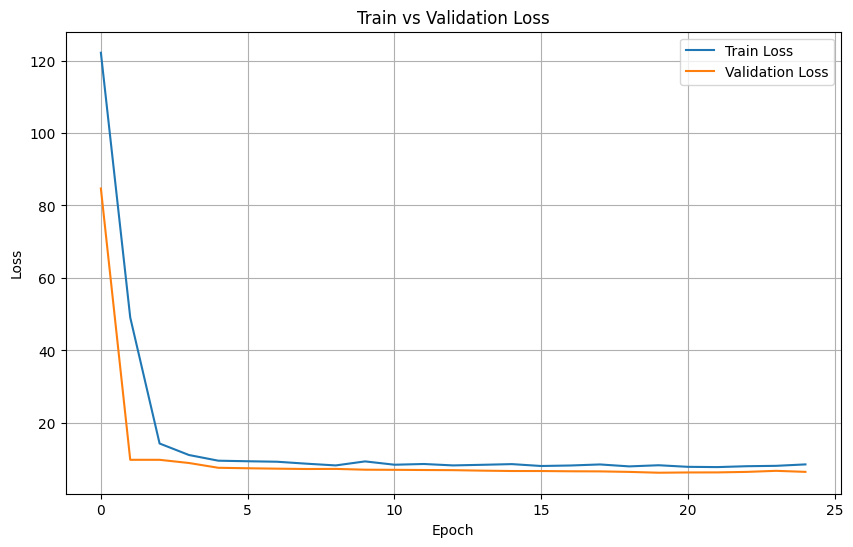

In [126]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [127]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Previsões
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# Transformando y_test para array (caso ainda seja Series)
y_true = y_test_tensor.cpu().numpy()

# Cálculo das métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.1879
RMSE: 2.9299
R²:   0.1197


In [128]:
index = 75
student = X_test_tensor[index]
y_true = y_test_tensor[index]
y_true

tensor([12.], device='cuda:0')

In [129]:
with torch.no_grad():
    y_pred = model(student).cpu().numpy()
y_pred

array([11.9535885], dtype=float32)

## Experiment 6: Adding an activation function

In [130]:
class Model6(nn.Module):
    def __init__(self):
        super(Model6, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(47, 120),
            nn.ReLU(),
            nn.Linear(120, 120),
            nn.ReLU(),
            nn.Linear(120, 1)
        )

    def forward(self, x):
        return self.net(x)

In [131]:
# Hiperparâmetros
n_epochs = 30
lr=1e-3
patience = 5

model = Model6()

criterion = nn.MSELoss()  # regressão → MSE
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses = trainModel(model,
           train_loader,
           val_loader,
           criterion,
           optimizer,
           n_epochs,
           patience)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 training loss: 136.0445
Epoch 1 validation loss: 119.6752
Epoch 2 training loss: 91.4597


 10%|█         | 3/30 [00:00<00:00, 29.90it/s]

Epoch 2 validation loss: 51.6535
Epoch 3 training loss: 24.3442
Epoch 3 validation loss: 10.3150
Epoch 4 training loss: 14.0579
Epoch 4 validation loss: 7.0325
Epoch 5 training loss: 9.4175
Epoch 5 validation loss: 7.2166


 10%|█         | 3/30 [00:00<00:00, 29.90it/s]

Epoch 6 training loss: 8.4908
Epoch 6 validation loss: 6.6443
Epoch 7 training loss: 8.1673


 23%|██▎       | 7/30 [00:00<00:00, 30.45it/s]

Epoch 7 validation loss: 6.3512
Epoch 8 training loss: 7.6920
Epoch 8 validation loss: 6.3121


 37%|███▋      | 11/30 [00:00<00:00, 30.39it/s]

Epoch 9 training loss: 7.5811
Epoch 9 validation loss: 6.3930
Epoch 10 training loss: 7.2436
Epoch 10 validation loss: 6.4261
Epoch 11 training loss: 7.0372
Epoch 11 validation loss: 6.3858
Epoch 12 training loss: 6.8765


 37%|███▋      | 11/30 [00:00<00:00, 30.39it/s]

Epoch 12 validation loss: 6.3621
Epoch 13 training loss: 6.6800


 40%|████      | 12/30 [00:00<00:00, 27.53it/s]

Epoch 13 validation loss: 6.3535
Early stopping triggered.


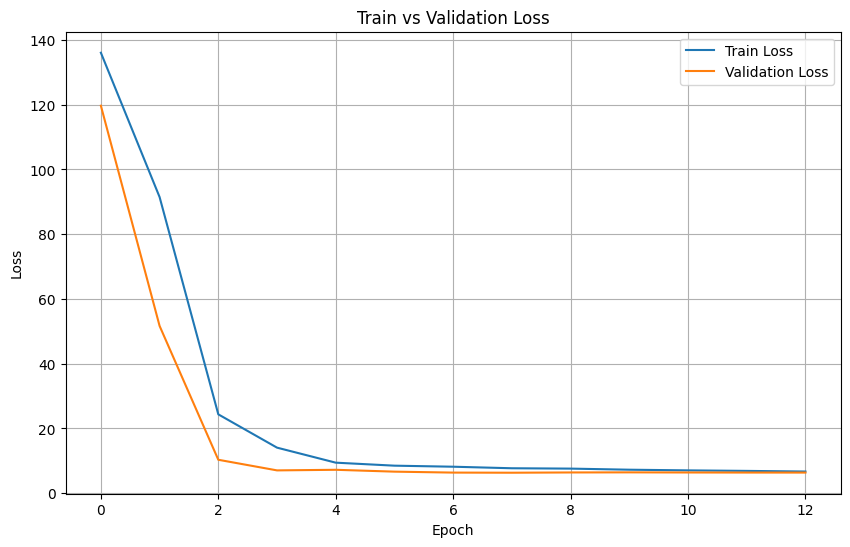

In [132]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Previsões
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# Transformando y_test para array (caso ainda seja Series)
y_true = y_test_tensor.cpu().numpy()

# Cálculo das métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.1737
RMSE: 2.9673
R²:   0.0971


In [134]:
index = 75
student = X_test_tensor[index]
y_true = y_test_tensor[index]
y_true

tensor([12.], device='cuda:0')

In [135]:
with torch.no_grad():
    y_pred = model(student).cpu().numpy()
y_pred

array([12.380562], dtype=float32)

## Experiment 7: ReLU + SGD 

In [153]:
class Model7(nn.Module):
    def __init__(self):
        super(Model7, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(47, 120),
            nn.ReLU(),
            nn.Linear(120, 120),
            nn.ReLU(),
            nn.Linear(120, 1)
        )

    def forward(self, x):
        return self.net(x)

In [154]:
# Hiperparâmetros
n_epochs = 30
lr=1e-3
patience = 5

model = Model7()

criterion = nn.MSELoss()  # regressão → MSE
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

train_losses, val_losses = trainModel(model,
           train_loader,
           val_loader,
           criterion,
           optimizer,
           n_epochs,
           patience)

  7%|▋         | 2/30 [00:00<00:01, 14.58it/s]

Epoch 1 training loss: 94.9813
Epoch 1 validation loss: 58.1307
Epoch 2 training loss: 27.1790
Epoch 2 validation loss: 21.4950
Epoch 3 training loss: 13.3870
Epoch 3 validation loss: 8.6637


 20%|██        | 6/30 [00:00<00:01, 16.27it/s]

Epoch 4 training loss: 8.4354
Epoch 4 validation loss: 7.6956
Epoch 5 training loss: 7.5789
Epoch 5 validation loss: 6.6941
Epoch 6 training loss: 6.6984
Epoch 6 validation loss: 6.8582
Epoch 7 training loss: 6.4568
Epoch 7 validation loss: 6.4776


 33%|███▎      | 10/30 [00:00<00:01, 17.74it/s]

Epoch 8 training loss: 6.0964
Epoch 8 validation loss: 6.5917
Epoch 9 training loss: 6.2024
Epoch 9 validation loss: 7.3312
Epoch 10 training loss: 6.2172
Epoch 10 validation loss: 7.0994
Epoch 11 training loss: 5.7739
Epoch 11 validation loss: 6.4825


 37%|███▋      | 11/30 [00:00<00:01, 15.67it/s]

Epoch 12 training loss: 5.5405
Epoch 12 validation loss: 6.6211
Early stopping triggered.


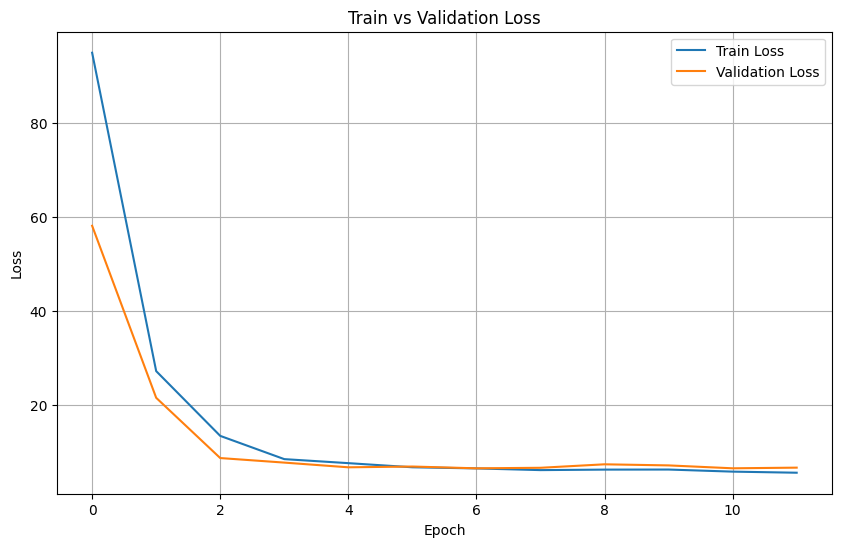

In [155]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [156]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Previsões
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# Transformando y_test para array (caso ainda seja Series)
y_true = y_test_tensor.cpu().numpy()

# Cálculo das métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  2.0935
RMSE: 2.8651
R²:   0.1582


In [157]:
index = 75
student = X_test_tensor[index]
y_true = y_test_tensor[index]
y_true

tensor([12.], device='cuda:0')

In [158]:
with torch.no_grad():
    y_pred = model(student).cpu().numpy()
y_pred

array([10.799215], dtype=float32)

## Results comparison

In [160]:
def highlight_results(val, col, baseline_dict, minmax_dict=None):
    baseline = baseline_dict[col]
    if minmax_dict is None:
        return ""
    vmin, vmax = minmax_dict[col]
    # For R², higher is better
    if col == "R²":
        if val > baseline:
            # Green gradient: interpolate between #ccffcc (light) and #38761d (dark)
            ratio = min(1, max(0, (val - baseline) / (vmax - baseline + 1e-8)))
            r = int(204 + (56-204)*ratio)
            g = int(255 + (118-255)*ratio)
            b = int(204 + (29-204)*ratio)
            color = f"background-color: rgb({r},{g},{b}); color: white"
        elif val < baseline:
            # Red gradient: interpolate between #f4cccc (light) and #990000 (dark)
            ratio = min(1, max(0, (baseline - val) / (baseline - vmin + 1e-8)))
            r = int(244 + (153-244)*ratio)
            g = int(204 + (0-204)*ratio)
            b = int(204 + (0-204)*ratio)
            color = f"background-color: rgb({r},{g},{b}); color: white"
        else:
            color = ""
    else:
        # For MAE and RMSE, lower is better
        if val < baseline:
            # Green gradient: interpolate between #ccffcc (light) and #38761d (dark)
            ratio = min(1, max(0, (baseline - val) / (baseline - vmin + 1e-8)))
            r = int(204 + (56-204)*ratio)
            g = int(255 + (118-255)*ratio)
            b = int(204 + (29-204)*ratio)
            color = f"background-color: rgb({r},{g},{b}); color: white"
        elif val > baseline:
            # Red gradient: interpolate between #f4cccc (light) and #990000 (dark)
            ratio = min(1, max(0, (val - baseline) / (vmax - baseline + 1e-8)))
            r = int(244 + (153-244)*ratio)
            g = int(204 + (0-204)*ratio)
            b = int(204 + (0-204)*ratio)
            color = f"background-color: rgb({r},{g},{b}); color: white"
        else:
            color = ""
    return color

def style_results(df):
    baseline_dict = df.iloc[0][["MAE", "RMSE", "R²"]].to_dict()
    minmax_dict = {}
    for col in ["MAE", "RMSE", "R²"]:
        minmax_dict[col] = (df[col].min(), df[col].max())
    return df.style.apply(
        lambda s: [highlight_results(v, s.name, baseline_dict, minmax_dict) if s.name in baseline_dict else "" for v in s],
        axis=0
    )

In [162]:
results = [
    # Model name, MAE, RMSE, R²
    ["Baseline", 2.2253, 2.9790, 0.0900],
    ["Exp 1: +Layer", 2.2774, 3.0379, 0.0536],
    ["Exp 2: +Neurons", 2.2054, 2.9024, 0.1362],
    ["Exp 3: SGD", 2.1992, 2.8871, 0.1452],
    ["Exp 4: AdamW", 2.2488, 2.9492, 0.1081],
    ["Exp 5: Dropout", 2.2091, 2.9371, 0.1154],
    ["Exp 6: ReLU", 2.1512, 2.9185, 0.1266],
    ["Exp 7: ReLU + SGD", 2.0935, 2.8651, 0.1582]
]

df_results = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²"])
styled = style_results(df_results)
display(styled)

,Model,MAE,RMSE,R²
0,Baseline,2.225300,2.979000,0.090000
1,Exp 1: +Layer,2.277400,3.037900,0.053600
2,Exp 2: +Neurons,2.205400,2.902400,0.136200
3,Exp 3: SGD,2.199200,2.887100,0.145200
4,Exp 4: AdamW,2.248800,2.949200,0.108100
5,Exp 5: Dropout,2.209100,2.937100,0.115400
6,Exp 6: ReLU,2.151200,2.918500,0.126600
7,Exp 7: ReLU + SGD,2.093500,2.865100,0.158200


# Baseline

O modelo baseline consiste em uma rede neural com duas camadas ocultas, cada uma contendo 120 neurônios, utilizando a função de ativação padrão, o otimizador Adam e sem Dropout. Ele obteve um MAE de 2.2253, RMSE de 2.9790 e um R² de 0.0900. Esses valores indicam uma performance inicial razoável, mas com espaço para melhorias tanto na precisão quanto na capacidade de explicação (R²).

# Experimento 1: +Layer

Neste experimento, foi adicionada uma terceira camada oculta com 120 neurônios, aumentando a profundidade da rede. A intenção era permitir a captura de padrões mais complexos nos dados. No entanto, o desempenho piorou: o MAE aumentou para 2.2774, o RMSE para 3.0379, e o R² caiu para 0.0536. Isso sugere que a rede mais profunda pode ter levado a overfitting ou dificultado a convergência do treinamento, sem benefícios claros na generalização.

# Experimento 2: +Neurons

Aqui, as duas camadas ocultas do modelo baseline foram mantidas, mas o número de neurônios em cada uma foi aumentado de 120 para 256 neurônios. O objetivo foi dar à rede maior capacidade de representação. Os resultados mostraram leve melhora: MAE caiu para 2.2054, RMSE para 2.9024 e R² subiu para 0.1362. A alteração aumentou a flexibilidade do modelo sem os prejuízos observados na adição de uma camada extra, o que mostra que mais neurônios foi mais benéfico do que mais camadas.

# Experimento 3: SGD

Neste experimento, foi mantida a arquitetura original do baseline, mas o otimizador Adam foi substituído por SGD (Stochastic Gradient Descent), com momentum igual a 0.9 e weight decay. Essa mudança busca testar um método de otimização mais simples, porém mais controlado. O modelo obteve melhorias: MAE de 2.1992, RMSE de 2.8871 e R² de 0.1452. Isso mostra que o SGD teve melhor desempenho na generalização, talvez por evitar os saltos maiores que o Adam pode provocar em algumas situações.

# Experimento 4: AdamW

A arquitetura original foi mantida, mas o otimizador Adam foi substituído pelo AdamW, que aplica regularização de maneira diferente (usando weight decay desacoplado do gradiente). O desempenho foi ligeiramente melhor que o baseline (MAE = 2.2488, RMSE = 2.9492, R² = 0.1081), mas inferior ao do SGD. Isso indica que, para esse conjunto de dados, o AdamW não trouxe ganhos significativos em relação ao Adam.

# Experimento 5: Dropout

Foi introduzido Dropout com taxa de 0.2 nas camadas ocultas da arquitetura do baseline, visando reduzir overfitting. O resultado teve leve melhora: MAE de 2.2091, RMSE de 2.9371 e R² de 0.1154. Isso mostra que o modelo baseline já estava relativamente bem regularizado, e o Dropout trouxe pequeno ganho na estabilidade, mas não foi uma mudança decisiva.

# Experimento 6: ReLU

Neste experimento, a arquitetura e os demais parâmetros foram mantidos, mas foi substituída a função de ativação padrão por ReLU (Rectified Linear Unit), entre as camadas. O desempenho melhorou: MAE caiu para 2.1512, e RMSE para 2.9185 e R² subiu para 0.1266. Isso sugere que a ReLU, ao introduzir a não linearidade ao sistema, facilitou o aprendizado e permitiu melhor extração de características.

# Experimento 7: ReLU + SGD

Este experimento combinou duas melhorias anteriores: a função de ativação ReLU e o otimizador SGD, mantendo a arquitetura original do baseline. O resultado foi o melhor entre todos os modelos testados: MAE de 2.0935, RMSE de 2.8651 e R² de 0.1582. Essa combinação tirou o melhor proveito da arquitetura original, mostrando que ajustes nos componentes do modelo (função de ativação e otimizador) foram mais impactantes do que mudanças estruturais.